In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

from local_utilities import load_as_df

In [2]:
stock_list = load_as_df('select * from base_stocks where market = "主板"')
stock_list = stock_list.set_index('ts_code')
code_list = list(stock_list.index)

s1,s2,s3,s4 = code_list[:500], code_list[500:1000], code_list[1000:1500], code_list[1500:]

In [33]:
ts_code = s1[0]
def trade_days(ts_code, start_day='2019-01-01'):
    df_days = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    return df_days

def find_spec(ts_code, start_day='2019-01-01'):
    df_days = trade_days(ts_code, start_day)
    chg_times, vol_times = 0, 0
    try:
        if df_days.shape[0] > 0:
            spec_arr = pd.qcut(np.abs(df_days.pct_chg), 10, duplicates='drop').value_counts()
            bar_chg = spec_arr.keys()[0].left
            bar_vol = pd.qcut(np.abs(df_days.vol), 10).value_counts().keys()[0].left
            chg_times, vol_times = df_days[-10:][df_days.pct_chg > bar_chg].shape[0], df_days[-10:][df_days.vol > bar_vol].shape[0]
    except Exception as e:
        print('ts_code:{}, err:{}'.format(ts_code, e))
    return (ts_code, chg_times, vol_times)

In [6]:
spec_list = []
for s in s1:
    spec_list.append(find_spec(s))

In [53]:
df_spec = pd.DataFrame(spec_list, columns=('ts_code', 'chg_times', 'vol_times'))
df_spec = df_spec.set_index('ts_code')
df_spec = df_spec[(df_spec.chg_times > 2) & (df_spec.vol_times > 1)].sort_values(by='chg_times', ascending=False)

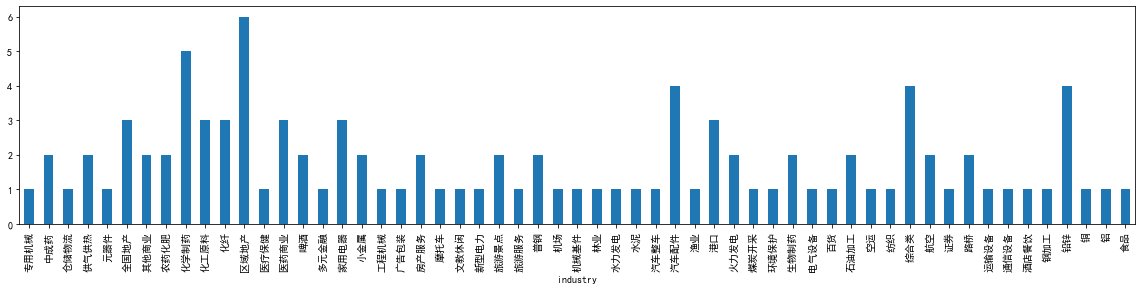

In [8]:
df_spec = df_spec.join(stock_list)
df_spec.groupby('industry', as_index=True).count()['symbol'].plot(kind='bar', figsize=(20,4))

In [62]:
df_all = pd.concat([df_spec,stock_list], axis=1)

Text(0, 0.5, 'price abnormal pct')

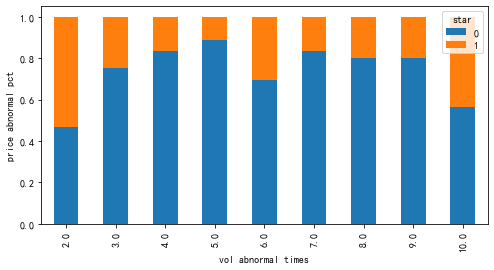

In [72]:
df_all[:4]
df_all['star'] = np.where(df_all.chg_times>5, 1, 0)
xt = pd.crosstab(df_all.vol_times, df_all.star )
xt_pct = xt.div(xt.sum(1).astype(float), axis=0)
xt_pct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.xlabel('vol abnormal times')
plt.ylabel('price abnormal pct')

In [19]:
from pprint import pprint
def visual_trend(ts_code, start_day='2019-01-01'):
    tf_trend = load_as_df('select * from tickers where ts_code = "{}" and trade_date >= "{}"'.format(ts_code, start_day))
    tf_trend.set_index('trade_date')
    pprint(tf_trend.head())
    # tf_trend[:12][['close','vol']].plot(subplots=True, grid=True, layout=(2,1), figsize=(12,6))

In [21]:
visual_trend('000411.SZ')

ts_code  trade_date   open   high    low  close  pre_close  change  \
0  000411.SZ  2019-01-02  12.60  12.64  12.18  12.18      12.64   -0.46   
1  000411.SZ  2019-01-03  12.12  12.30  12.00  12.00      12.18   -0.18   
2  000411.SZ  2019-01-04  11.95  12.25  11.78  12.21      12.00    0.21   
3  000411.SZ  2019-01-07  12.20  12.46  12.13  12.44      12.21    0.23   
4  000411.SZ  2019-01-08  12.44  12.54  12.30  12.34      12.44   -0.10   

   pct_chg       vol     amount  
0  -3.6392  10641.88  13167.916  
1  -1.4778   8048.00   9772.519  
2   1.7500  11233.10  13550.574  
3   1.8837   8839.27  10909.754  
4  -0.8039   8390.80  10396.422  


In [42]:
# bins = [-np.inf, 60, 80, 100, np.inf]
# pd.cut(np.arange(1000)%100,bins=bins).value_counts()

tdays = trade_days(ts_code='000411.SZ')
tdays = tdays.set_index('trade_date')
tchgs = pd.qcut(np.abs(tdays.pct_chg), 5)

In [51]:
pd.get_dummies(tchgs)


,"(-0.001, 0.413]","(0.413, 0.845]","(0.845, 1.492]","(1.492, 2.538]","(2.538, 10.014]"
trade_date,,,,,
2019-01-02,0,0,0,0,1
2019-01-03,0,0,1,0,0
2019-01-04,0,0,0,1,0
2019-01-07,0,0,0,1,0
2019-01-08,0,1,0,0,0
...,...,...,...,...,...
2020-07-27,0,0,0,0,1
2020-07-28,0,0,0,0,1
2020-07-29,0,0,0,0,1
